# Суть эксперимента

Рассмотрим алгоритм Франка-Вульфа для шага вида
$$\alpha_k = \alpha_k(L) := \min \{ -\frac{\nabla f(x_k)^\top d_k}{L ||d_k||^2_2}, 1 \}$$


Мы показали, что если функция обладает свойством относительной гладкости, то для метода Франка-Вульфа с  шагом вида:
$$\alpha_k = \alpha_k(L) := \min \{ (\frac{-\nabla f(x_k)^\top d_k}{2 L V(s^k, x^k)})^{1/(\gamma - 1)}, 1 \}$$
, где $V$ - дивергенция Брегмана, $1 < \gamma \leq 2$ - степень из свойства Triangle Scaling Exponent https://arxiv.org/pdf/1808.03045.pdf


Теперь посмотрим, что будет, если заместо шага с Евклидовой нормой ставить дивергенцию (то есть применять второй шаг)

## Постановка задачи
Рассмотрим задачу Poisson linear inverse problem без регуляризации
$$
\textrm{minimize} \quad F(x):= D_{KL}(b, Ax) \\
\textrm{s.t.} \ x\in \| x - c \| \leq R
$$

$x \in \mathbb{R}^n_{++}, A \in \mathbb{R}^{m \times n}_{++}, b \in \mathbb{R}_{++}$

Начальная точка выбирается случайно внутри шара. Возьмём $R=100, с = [100, 100,...]$

Сравним динамику сходимости для дивергенций: \\

- Бёрга:  h(x) = - sum_{i=1}^n log(x[i]) с gamma = 2 \\

- Шеннона: h(x) = sum_{i=1}^n x[i]*log(x[i]) с gamma = 2 \\

- Евклидовой нормы: h(x) = (1/2)||x||_2^2 с gamma = 2 \\

In [33]:
import numpy as np
import accbpg

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16, 'legend.fontsize':14, 'font.family': 'serif'})

In [39]:
from accbpg import BurgEntropy, PoissonRegression, SquaredL2Norm, ShannonEntropy
from accbpg.utils import random_point_in_l2_ball


def Poisson_regr_diff_divs(m, n, radius=1, center=None, noise=0.01, lamda=0, randseed=-1, normalizeA=True):
    if center is None:
        center = np.array([radius] * n)

    if randseed > 0:
        np.random.seed(randseed)
    A = np.random.rand(m, n) * (radius / 2)
    if normalizeA:
        A = A / A.sum(axis=0)  # scaling to make column sums equal to 1
    x = random_point_in_l2_ball(center=center, radius=radius)
    xavg = x.sum() / x.size
    x = np.maximum(x - xavg, 0) + center
    assert np.linalg.norm(x - center) <= radius
    b = np.dot(A, x) + noise * (np.random.rand(m) - 0.5)
    assert b.min() > 0, "need b > 0 for nonnegative regression."

    f = PoissonRegression(A, b)
    [burg_h, sqL2_h, shannon] = BurgEntropy(), SquaredL2Norm(), ShannonEntropy()
    L = b.sum()
    x0 = random_point_in_l2_ball(center, radius)
    assert np.linalg.norm(x0 - center) <= radius

    return f, [burg_h, sqL2_h, shannon], L, x0, x

Подготовим данные

In [35]:
maxitrs = 1000
m = 10 # параметр m
n = 100 # параметр n
radius = 100 # радиус шара
noise = 0 # уберём шум, так как в нашем примере нет регуляризации
ls_ratio = 2 # степень, на которую убывает константа липшица L при backtracking search

Запускаем алгоритмы

In [ ]:
f, [burg_h, sqL2_h, shannon_h], L, x0, solution = accbpg.Poisson_regr_diff_divs(m, n, radius=radius, noise=noise, lamda=0.001, randseed=1, normalizeA=False)

x00_burg, F00_burg, G00_burg, T00_burg = accbpg.FW_alg_div_step(f, burg_h, L, x0, lmo=accbpg.lmo_notnegative_ball(radius, is_shifted_pos_ball=True), maxitrs=maxitrs, gamma=2.0, ls_ratio=ls_ratio, verbskip=1000)

x00_sq, F00_sq, G00_sq, T00_sq = accbpg.FW_alg_div_step(f, sqL2_h, L, x0, lmo=accbpg.lmo_notnegative_ball(radius, is_shifted_pos_ball=True), maxitrs=maxitrs, gamma=2.0, ls_ratio=ls_ratio, verbskip=1000)

x00_sh, F00_sh, G00_sh, T00_sh = accbpg.FW_alg_div_step(f, shannon_h, L, x0, lmo=accbpg.lmo_notnegative_ball(radius, is_shifted_pos_ball=True), maxitrs=maxitrs, gamma=2.0, ls_ratio=ls_ratio, verbskip=1000)

Графики

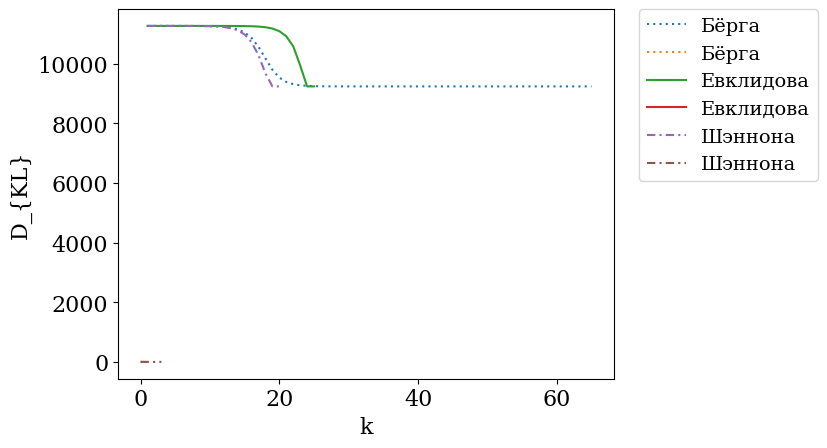

In [41]:
labels = [r"Бёрга", r"Евклидова", r"Шэннона"]
styles = ['k:', 'g-', 'b-.', 'k-', 'r--', 'y-']
dashes = [[1, 2], [], [4, 2, 1, 2], [], [4, 2], []]

fig, axis = plt.subplots()
y_vals = [F00_burg, F00_sq, F00_sh]

for i in range(len(y_vals)):
    xi = np.arange(len(y_vals[i])) + 1
    axis.plot(xi, y_vals[i], dashes[i], label=labels[i], dashes=dashes[i])

axis.set_xlabel("k")
axis.set_ylabel("D_{KL}")

axis.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)